# Show the Data Spectra and Compare it with simulations

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [153]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [154]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

### import

In [155]:
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [156]:
from scipy import interpolate

In [157]:
import seaborn as sns

In [158]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [159]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [160]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [161]:
PATH_SPECTRACTOR='../../Spectractor'
PATH_SPECTRACTORSIM='../../SpectractorSim'
PATH_GMAOMERRA='../merra2'

In [162]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_GMAOMERRA)

In [163]:
from spectractor import *
from spectractorsim import *

## Input spectra

### LogBook

In [164]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [165]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [166]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [167]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [168]:
home=os.getenv('HOME')

In [169]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [170]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [171]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [172]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [173]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [174]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [175]:
PATH_SPECTRACTORSIM

'../../SpectractorSim'

In [176]:
path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

In [177]:
path_sim

'../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'

## Selection of night

In [178]:
date="20170529"

In [179]:
idx_sel_subdir=1

### Logbook

In [180]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [181]:
all_obs_extr=all_obs[["index","object"]]

### path for spectra

In [182]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [183]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [184]:
def get_index_from_filename(ffilename,the_searchtag):
    fn=os.path.basename(ffilename)
    sel_index= int(re.findall(the_searchtag,fn)[0])
    return sel_index

In [185]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    all_sel_indexes.append(sel_index)
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [186]:
#SelFlag=[]
#for index, row in all_obs.iterrows():
#  if row["index"] in all_sel_indexes:
#    SelFlag.append(True)
#  else:
#    SelFlag.append(False)
#sel_obs=all_obs[SelFlag]

In [187]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [188]:
sel_obs.head()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T00:07:29.654,48,779,4,48,"1,049","1,199",60,HD111980,dia,Ron400,12400,"13,1",data_29may17,reduc_20170529_048.fits
2017-05-30T00:09:13.188,49,779,"3,9",48,"1,048","1,22",60,HD111980,dia,Ron400,12400,"9,3",data_29may17,reduc_20170529_049.fits
2017-05-30T00:11:05.597,50,779,4,48,"1,046","1,258",60,HD111980,dia,Thor300,12400,"8,5",data_29may17,reduc_20170529_050.fits
2017-05-30T00:12:49.126,51,779,"4,1",48,"1,044","1,127",60,HD111980,dia,Thor300,12400,"8,1",data_29may17,reduc_20170529_051.fits
2017-05-30T00:14:41.448,52,779,"4,1",47,"1,043","1,336",60,HD111980,dia,HoloPhP,12400,"8,7",data_29may17,reduc_20170529_052.fits


In [189]:
sel_obs.tail()

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,
2017-05-30T02:43:12.845,78,779,"3,4",42,"1,102","1,39",360,HD111980,RG715,HoloPhAg,12500,"8,9",data_29may17,reduc_20170529_078.fits
2017-05-30T02:49:56.369,79,779,"3,6",40,"1,114","1,467",360,HD111980,RG715,HoloPhAg,12500,"10,3",data_29may17,reduc_20170529_079.fits
2017-05-30T02:56:48.654,80,779,"3,4",41,"1,128","2,524",360,HD111980,RG715,HoloAmAg,12500,"14,1",data_29may17,reduc_20170529_080.fits
2017-05-30T03:03:32.183,81,779,"3,2",40,"1,143","2,075",360,HD111980,RG715,HoloAmAg,12500,"11,5",data_29may17,reduc_20170529_081.fits
2017-05-30T09:52:30.903,150,780,"2,5",35,"1,853","1,363",120,HD185975,dia,HoloPhAg,12650,"9,4",data_29may17,reduc_20170529_150.fits


### Quick view on the kind of sources

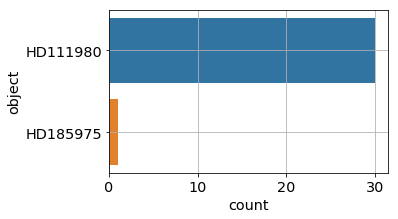

In [190]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

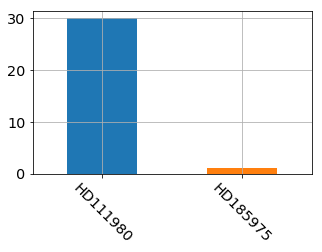

In [191]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad sources

- remove star **PNG336.3-05.6**

In [192]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6'])]
bad_indexes=bad_obs["index"]

In [193]:
bad_obs

,index,P,T,RH,airmass,seeing,exposure,object,filter,disperser,focus,W,subdir,file
date,,,,,,,,,,,,,,


In [194]:
bad_indexes=bad_obs.loc[:,"index"]

In [195]:
bad_indexes.index

Index([], dtype='object', name=u'date')

In [196]:
bad_indexes.values

array([], dtype=int64)

- keep stars **HD111980**, **HD205905**

In [197]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD111980','HD185975'])]

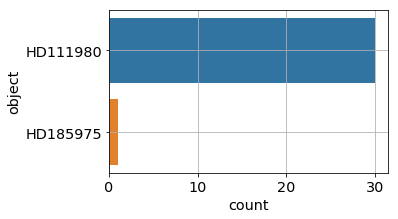

In [198]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [199]:
list_of_objects=sel2_obs['object'].values

In [200]:
list_of_objects=set(list_of_objects)

In [201]:
list_of_objects=list(list_of_objects)

In [202]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [203]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [204]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [205]:
all_simspectrafiles1[:3]

['../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/clearsky/specsim_20170529_048_spectrum.fits',
 '../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/clearsky/specsim_20170529_049_spectrum.fits',
 '../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/clearsky/specsim_20170529_050_spectrum.fits']

In [206]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [207]:
all_simspectrafiles2[:3]

['../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/standard/specsim_20170529_048_spectrum.fits',
 '../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/standard/specsim_20170529_049_spectrum.fits',
 '../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/standard/specsim_20170529_050_spectrum.fits']

In [208]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [209]:
all_simspectrafiles3[:3]

['../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/merra2/specsim_20170529_048_spectrum.fits',
 '../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/merra2/specsim_20170529_049_spectrum.fits',
 '../../SpectractorSim/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra/data_29may17/merra2/specsim_20170529_050_spectrum.fits']

# Remove bad indexes

In [210]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

In [211]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

In [212]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

In [213]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

# which filters

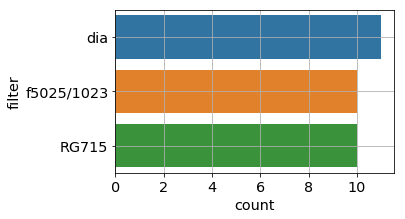

In [214]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

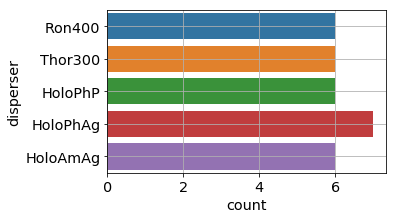

In [215]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [216]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [217]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [218]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [219]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [220]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

In [221]:
def PlotSpectra(the_filelist,the_obs,the_searchtag,the_title):
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser
    
    plt.figure(figsize=(10,8))
    for the_file in the_filelist:
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:
            hdu = fits.open(the_file)
            data=hdu[0].data
            wl=data[0]
            fl=data[1]
            plt.plot(wl,fl)
    plt.grid()    
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")   

## Show the reconstructed spectra

In [222]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170529_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [223]:
thetitle="Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

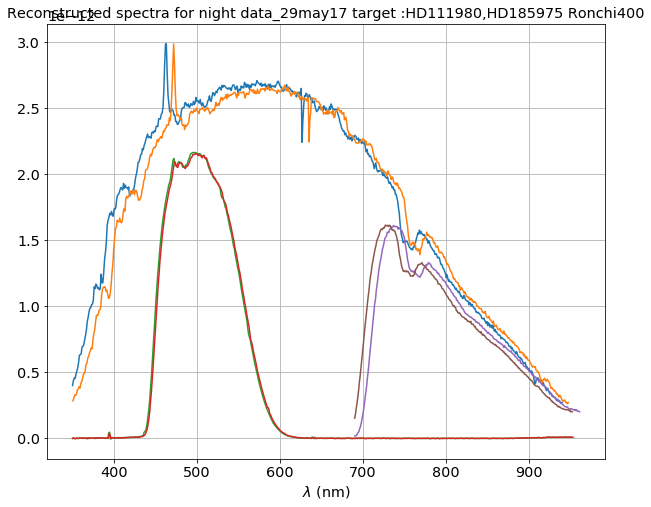

In [224]:
PlotSpectra(all_spectrafiles,sel_obs_Ron400,SearchTagRe,thetitle)

### Thor 300

In [225]:
thetitle="Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

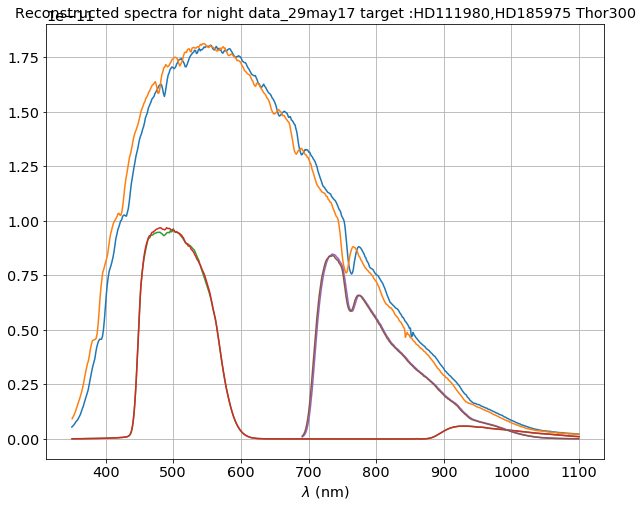

In [226]:
PlotSpectra(all_spectrafiles,sel_obs_Thor300,SearchTagRe,thetitle)

### HoloPhP

In [227]:
thetitle="Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

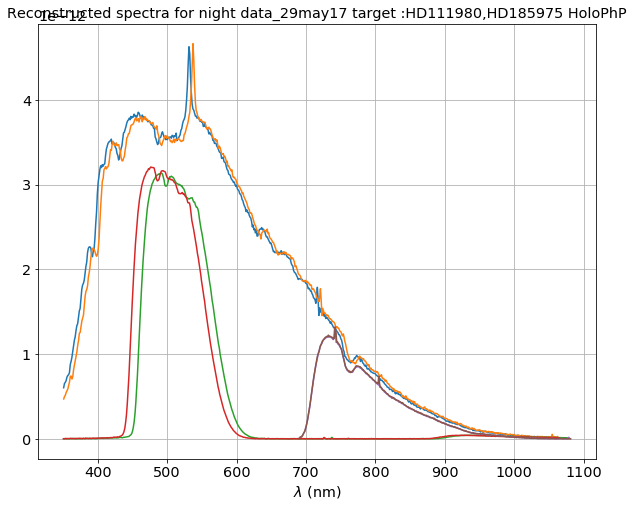

In [228]:
PlotSpectra(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,thetitle)

### HoloPhAg

In [229]:
thetitle="Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

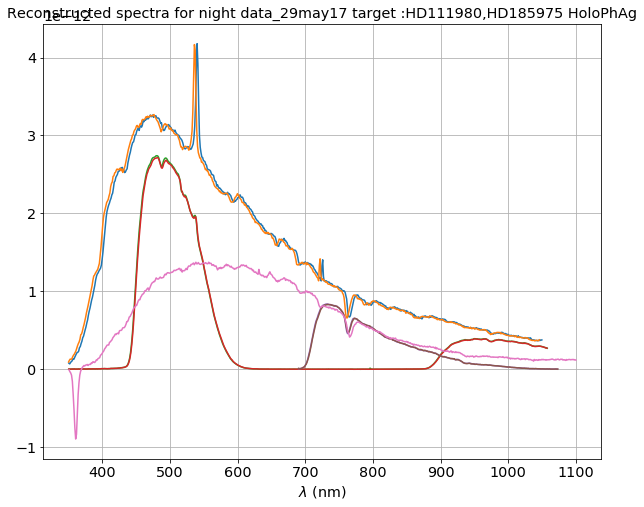

In [230]:
PlotSpectra(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,thetitle)

### HoloAmAg

In [231]:
thetitle="Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

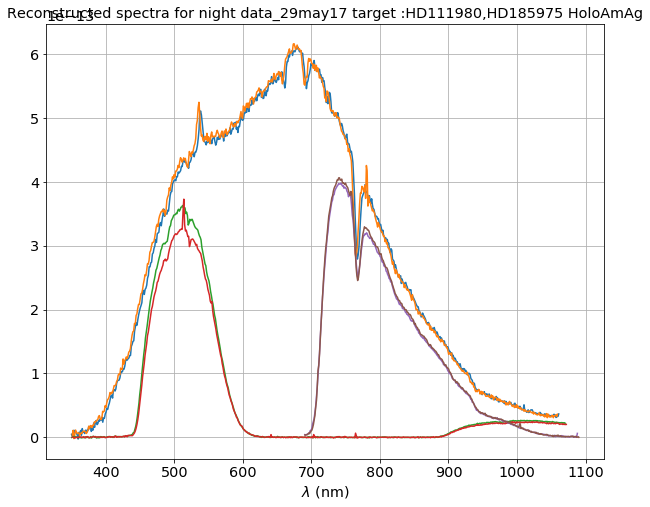

In [232]:
PlotSpectra(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,thetitle)

## Show the simulated spectra

In [233]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [234]:
thetitle="sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

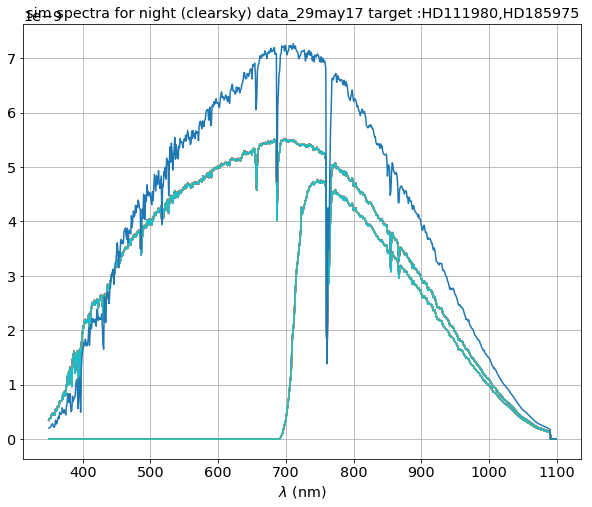

In [235]:
PlotSpectra(all_simspectrafiles1,sel2_obs,SearchTagRe,thetitle)

### standard sky

In [236]:
thetitle="sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

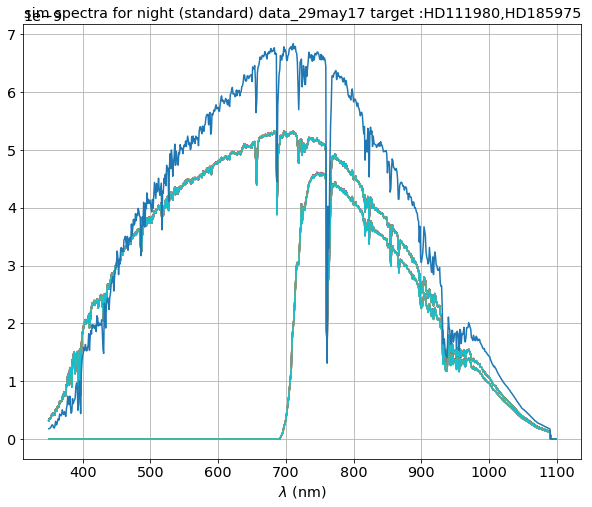

In [237]:
PlotSpectra(all_simspectrafiles2,sel2_obs,SearchTagRe,thetitle)

### merra2 sky

In [238]:
thetitle="sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

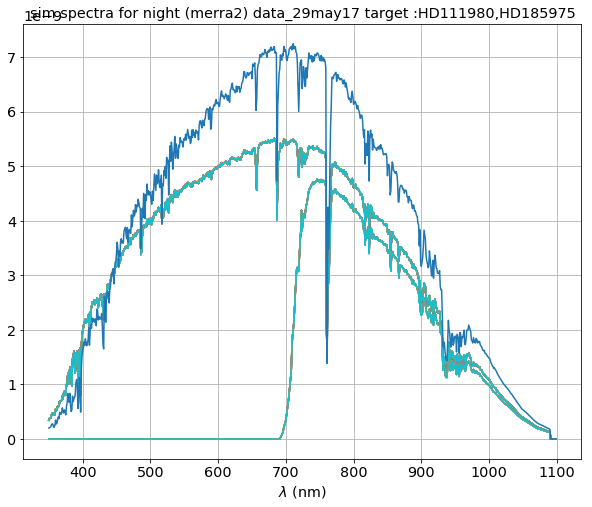

In [239]:
PlotSpectra(all_simspectrafiles3,sel2_obs,SearchTagRe,thetitle)

# Spectra ratio data/sim

In [240]:
def PlotSpectraRatio(the_filelist,path_tosims,the_obs,the_searchtag,the_title):
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser
    
    plt.figure(figsize=(10,8))
    for the_file in the_filelist:  # loop on reconstruted spectra
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:                # check if tthe index is in the disperser indexes 
            basefn=os.path.basename(the_file)                  # basename of reconstruced spectra
            basefn2=basefn.replace('reduc','specsim')  # reconstruct the simulation filename
            the_filesim=os.path.join(path_tosims,basefn2)  # add the path for the simulated file
            
            hdu1 = fits.open(the_file)
            data1=hdu1[0].data
            wl1=data1[0]
            fl1=data1[1]
            
            # extend range for (wl1,fl1)
            wl1=np.insert(wl1,0,WL[0])
            fl1=np.insert(fl1,0,0.)
            
            wl1=np.append(wl1,WL[-1])
            fl1=np.append(fl1,0.)
            
            hdu2 = fits.open(the_filesim)
            data2=hdu2[0].data
            wl2=data2[0]
            fl2=data2[1]
            
            func = interpolate.interp1d(wl1, fl1)
            fl0=func(WL)
            
            plt.plot(WL,fl0/fl2)
    plt.grid()    
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")   
    plt.ylabel("spectra ratio")  

In [241]:
def PlotSpectraLogRatio(the_filelist,path_tosims,the_obs,the_searchtag,the_title):
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser
    
    plt.figure(figsize=(10,8))
    for the_file in the_filelist:  # loop on reconstruted spectra
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:                # check if tthe index is in the disperser indexes 
            basefn=os.path.basename(the_file)                  # basename of reconstruced spectra
            basefn2=basefn.replace('reduc','specsim')  # reconstruct the simulation filename
            the_filesim=os.path.join(path_tosims,basefn2)  # add the path for the simulated file
            
            hdu1 = fits.open(the_file)
            data1=hdu1[0].data
            wl1=data1[0]
            fl1=data1[1]
            
            # extend range for (wl1,fl1)
            wl1=np.insert(wl1,0,WL[0])
            fl1=np.insert(fl1,0,0.)
            
            wl1=np.append(wl1,WL[-1])
            fl1=np.append(fl1,0.)
            
            hdu2 = fits.open(the_filesim)
            data2=hdu2[0].data
            wl2=data2[0]
            fl2=data2[1]
            
            func = interpolate.interp1d(wl1, fl1)
            fl0=func(WL)
            
            plt.plot(WL,2.5*(np.log10(fl0)-np.log10(fl2)))
    plt.grid()    
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")  
    plt.ylabel("log of spectra ratio")  

In [242]:
def SaveSpectraRatio(the_filelist,path_tosims,the_obs,the_searchtag,the_ratio_file):
    
    all_ratio_arr=np.zeros((1,len(WL)))
    all_ratio_arr[0,:]=WL
    
    the_selected_indexes=the_obs["index"].values  # get the array of index for that disperser    
    for the_file in the_filelist:  # loop on reconstruted spectra
        idx=get_index_from_filename(the_file,the_searchtag)
        if idx in the_selected_indexes:                # check if tthe index is in the disperser indexes 
            basefn=os.path.basename(the_file)                  # basename of reconstruced spectra
            basefn2=basefn.replace('reduc','specsim')  # reconstruct the simulation filename
            the_filesim=os.path.join(path_tosims,basefn2)  # add the path for the simulated file
            
            hdu1 = fits.open(the_file)
            header1=data1=hdu1[0].header
            airmass=header1["airmass"]
            target=header1["target"]
            
            data1=hdu1[0].data
            wl1=data1[0]
            fl1=data1[1]
            
            # extend range for (wl1,fl1)
            wl1=np.insert(wl1,0,WL[0])
            fl1=np.insert(fl1,0,0.)
            
            wl1=np.append(wl1,WL[-1])
            fl1=np.append(fl1,0.)
            
            hdu2 = fits.open(the_filesim)
            data2=hdu2[0].data
            wl2=data2[0]
            fl2=data2[1]
            
            func = interpolate.interp1d(wl1, fl1)
            fl0=func(WL)
            ratio=fl0/fl2
            new_ratio=np.expand_dims(ratio, axis=0)
            all_ratio_arr=np.append(all_ratio_arr,new_ratio,axis=0)
            
            
    hdu = fits.PrimaryHDU(all_ratio_arr)
    hdul = fits.HDUList([hdu])
    hdul.writeto(the_ratio_file,overwrite=True)
    
    return all_ratio_arr           

In [243]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

## spectra ratio for Ronchi 400

In [244]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


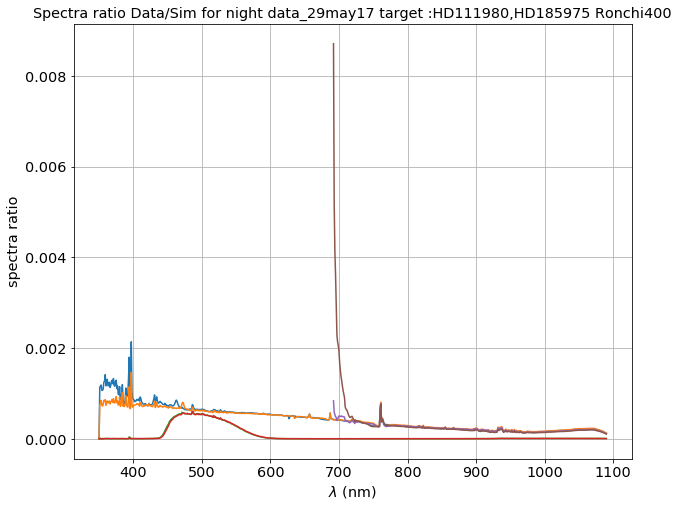

In [245]:
PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,thetitle)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


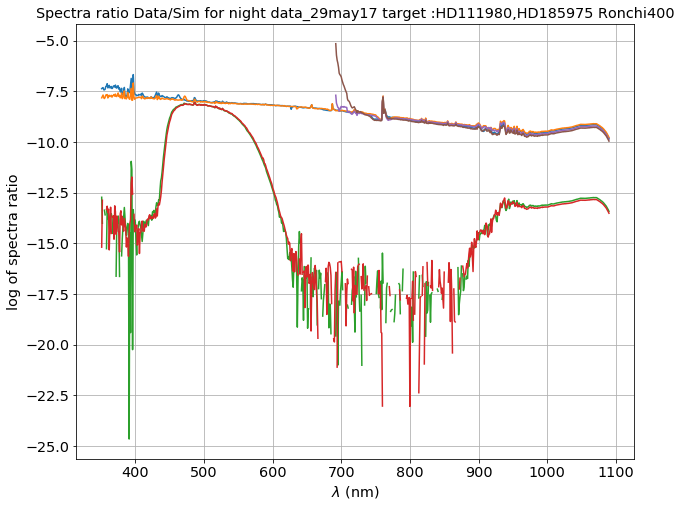

In [246]:
PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,thetitle)

In [247]:
arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Ron400,SearchTagRe,"ratio_Ron400.fits")

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


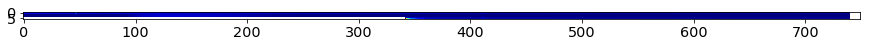

In [248]:
plt.imshow(arr[1:,:],cmap='jet')

## spectra ratio for Thor300

In [249]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


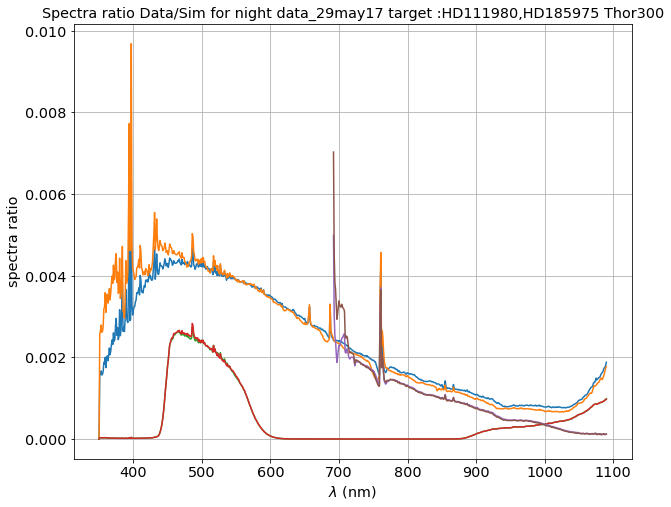

In [250]:
PlotSpectraRatio(all_spectrafiles,path_sim1,sel_obs_Thor300,SearchTagRe,thetitle)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


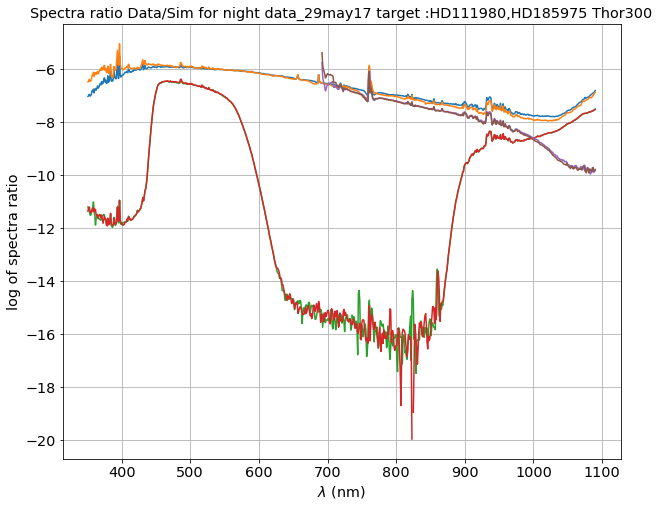

In [251]:
PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_Thor300,SearchTagRe,thetitle)

In [252]:
arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_Thor300,SearchTagRe,"ratio_Thor300.fits")

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


## spectra ratio for HoloPhP

In [253]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


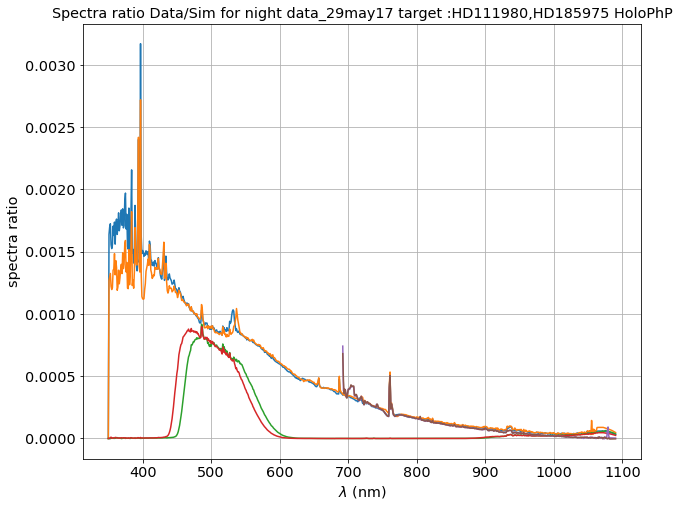

In [254]:
PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhP,SearchTagRe,thetitle)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


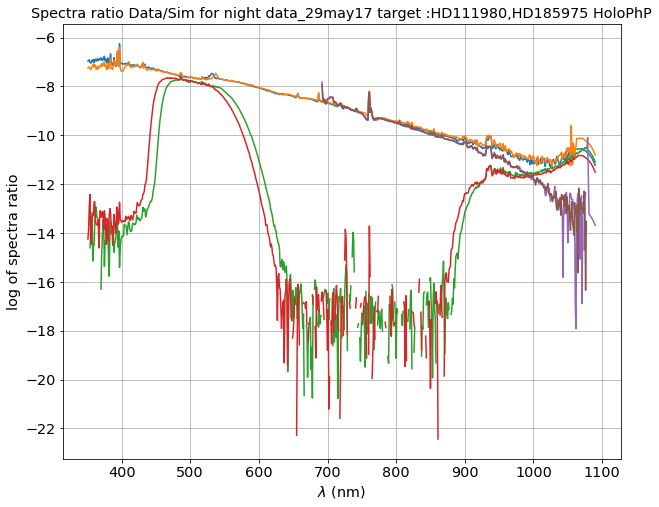

In [255]:
PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhP,SearchTagRe,thetitle)

In [256]:
arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhP,SearchTagRe,"ratio_HoloPhP.fits")

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


## Spectrum ratio for HoloPhAg

In [257]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


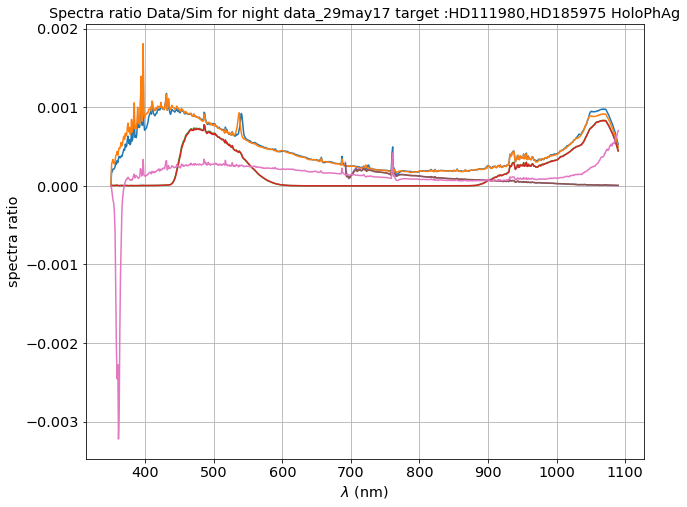

In [258]:
PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhAg,SearchTagRe,thetitle)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10


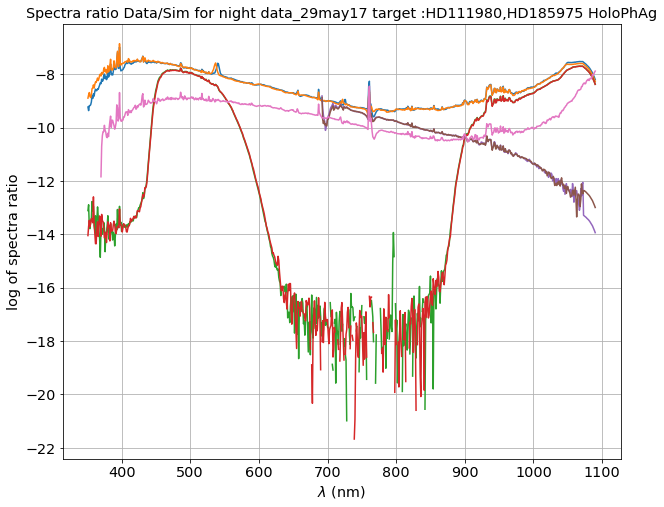

In [259]:
PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhAg,SearchTagRe,thetitle)

In [260]:
arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloPhAg,SearchTagRe,"ratio_HoloPhAg.fits")

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


## Spectrum ratio for HoloAmAg

In [261]:
thetitle="Spectra ratio Data/Sim for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


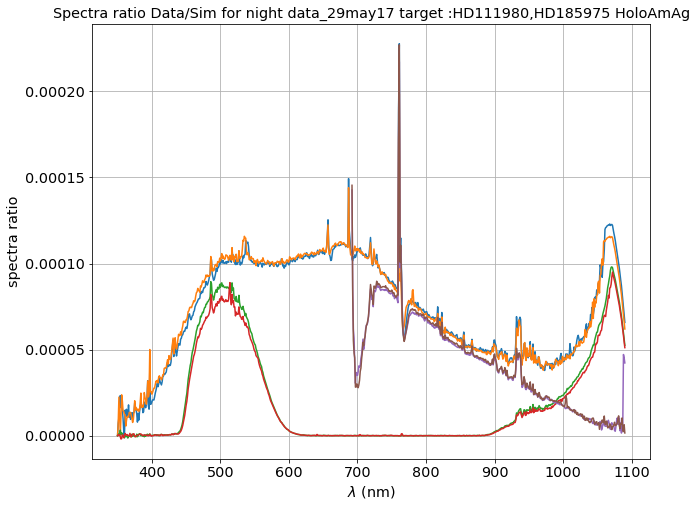

In [262]:
PlotSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,thetitle)

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log10
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in subtract


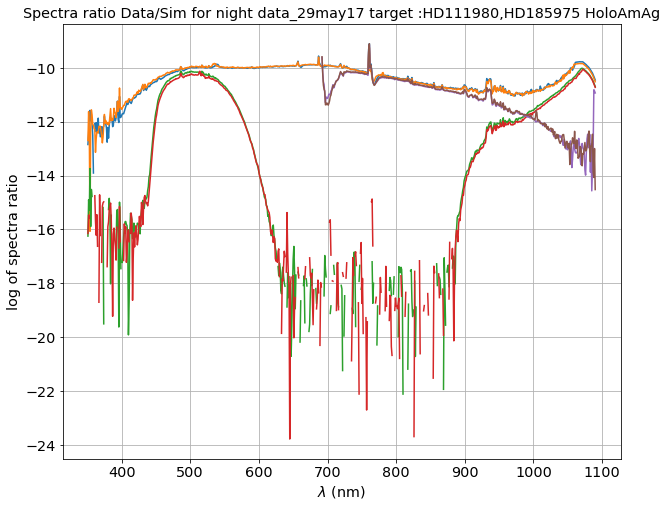

In [263]:
PlotSpectraLogRatio(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,thetitle)

In [264]:
arr=SaveSpectraRatio(all_spectrafiles,path_sim3,sel_obs_HoloAmAg,SearchTagRe,"ratio_HoloAmAg.fits")

/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide
/Users/dagoret/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in divide


In [265]:
!ls *.fits

ratio_HoloAmAg.fits ratio_HoloPhP.fits  ratio_Thor300.fits
ratio_HoloPhAg.fits ratio_Ron400.fits
